# Training a segmentation model for layout recognition with YALTAi and YOLOv8

This example has been used to produce an object classification model for images of books printed around the 16th - 18th centuries. The aim is to facilitate the process of image occlusion, while preserving the semantic value of the layout.

Resources :
- [**YALTAi**](https://github.com/ponteineptique/yaltai) : CLI for kraken engine aptation with YOLOv8 API
- [**Yolov8**](https://docs.ultralytics.com/) : Deep learning vision engin for object detection and image segmention. Provides by ultralytics API
- [**SegmOnto**](https://segmonto.github.io/) : Controlled vocabulary for the description of printed and manuscript books to describe content and layout

Dataset :
- Gallic(orpor)a : [link](https://github.com/Gallicorpora)
- FoNDUE : [link](https://github.com/FoNDUE-HTR)
- SETAF-Pierre-de-Vingle : [link](https://github.com/SETAFDH/HTR-SETAF-Pierre-de-Vingle)

*The computations were performed at University of Geneva using Baobab HPC service.*

## Producing classification vision model

### Prepare dataset

You need to group your XML-ALTO data in a single folder so that you can transform it into the YOLO format used by the Ultralytics API. Check that your zone names are consistent, so as not to multiply the number of classes, thereby reducing model quality. Ideally, your dataset should be structured as follows: `dataset/[BookId]/[IdImg]/`.

In [2]:
dataset = 'PATH/TO/DATA/'

For virtual environnement dedicated to yaltai:
`pip install yaltai`

In [ ]:
# convert alto data to yolo data

!yaltai alto-to-yolo PATH/TO/ALTOorPAGE/*.xml my-dataset --shuffle .1 --segmonto region

You'll find your new dataset, converted to YOLO format, in my-dataset or under the name you specified.

It may be necessary to modify certain parameters if you move your dataset to exercise the model, for example on a calculation server. You need to change the values of `train` and `val` to indicate the new absolute path within the `config.yml`.

###  Training a model

You can use the YALTAi library CLI to facilitate model training. In our case, we've chosen to use the ultralytics API directly, to go a step further in refining the model.

If you wish to use this method, we recommend that you install ultralytics in a new environment to ensure that you have the latest updates.

`pip install ultralytics`

#### Dashboard

You can use the *Comet* dashboard to track your training progress. The implementation is native to the ultralytics API. All you need to do is install the library.
Here, we indicate the various pieces of information when instantiating a class, although it is possible to import this information as an environment variable.
For documentation, please refer to https://www.comet.com/docs/v2/

`pip install comet-ml`

In [1]:
import comet_ml

comet_ml.init(api_key='API-KEY', project_name='NOM_PROJET', workspace='PSEUDO')

#### TRAINING

Here are the parameters we used to produce the model.
To do this, we used the following resources:
- GPU : 2 RTX Titan with 24 Gb RAM
- CPU : 12 Cores
- RAM : 25 Gb

time : 08:55:47

Pour les utilisateur du serveur de calcul de l'HPC de l'Université de Genève, vous pouvez retrouver l'exemple de script de lancement `SBATCH` ici : [FoNDUE](https://github.com/FoNDUE-HTR/Documentation/blob/master/CLUSTERS.md) 

In [ ]:
import os
import torch
from ultralytics import YOLO

# empty CUDA cache
torch.cuda.empty_cache()

# load pretrained model
model = YOLO('yolov8x.pt') #it's huge model, you can use other little model if you want.
model.to('cuda')

# get config path
dataset_path = os.getcwd() + dataset + 'config.yml'


#train
model.train(data=dataset_path, 
                      epochs=300, 
                      patience=150, 
                      imgsz=896, #image size pixel
                      batch=32, # it's big batch depending to your GPU Ram capacity
                      cache=True, # RAM caching
                      device=[0,1]) # for multiprocessing GPU, you can use only one GPU. You need only to put number device (generally 0)

# VAL/PREDICT/Benchmark

In [2]:
!ls models/

best.pt  last.pt


In [1]:
from ultralytics import YOLO

model = YOLO('models/best.pt')
model.to('cuda')
model.info()

Model summary: 365 layers, 68165127 parameters, 0 gradients, 258.2 GFLOPs


(365, 68165127, 0, 258.1870592)

## Eval

In [2]:
metrics = model.val(data = '/home/rayondemiel/Grand_Siecle/yolov8-testing/data/dataset-GallicorporaXVIXVIIIxFonduexSETAF/config.yml', plots=True)  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps

Model summary (fused): 268 layers, 68136087 parameters, 0 gradients, 257.5 GFLOPs
val: Scanning /home/rayondemiel/Grand_Siecle/yolov8-testing/data/dataset-GallicorporaXVIXVIIIxFonduexSETAF/val/labels.ca
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:10<
                   all        259        834      0.958      0.954      0.964      0.757
              MainZone        259        245       0.98      0.967      0.984      0.962
      RunningTitleZone        259        101      0.981       0.99      0.991      0.776
         NumberingZone        259         97      0.914      0.938      0.961      0.537
        QuireMarksZone        259        149      0.935      0.958      0.953       0.64
             StampZone        259         19      0.949      0.989      0.993      0.742
           GraphicZone        259         48      0.939      0.938      0.944      0.845
        MarginTextZone        259        126      0.9

array([    0.96232,     0.77561,     0.53663,     0.64036,     0.74197,     0.84491,     0.70096,     0.84254,     0.75281,       0.775,     0.75731,     0.75731,     0.75731])

## Predict

In [5]:
import requests
from io import BytesIO
from PIL import Image

def get_img(url: str):
    # download image
    response = requests.get(url)
    # open image with PIL library
    image = Image.open(BytesIO(response.content))
    return image


0: 896x512 1 MainZone, 1 StampZone, 1 GraphicZone, 1 TitlePageZone, 245.7ms
Speed: 7.4ms preprocess, 245.7ms inference, 1.9ms postprocess per image at shape (1, 3, 896, 512)


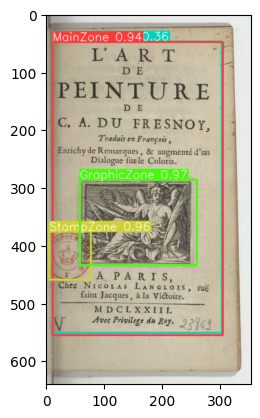

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

img = get_img("https://gallica.bnf.fr/iiif/ark:/12148/bpt6k97850416/f11/full/,640/0/native.jpg")
results = model(img)

results

for r in results:
    im_array = r.plot(conf=True)  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)
    plt.show()


0: 896x896 1 MainZone, 1 RunningTitleZone, 1 DropCapitalZone, 1: 896x896 1 MainZone, 1 StampZone, 1 GraphicZone, 1 MarginTextZone, 1 TitlePageZone, 2: 896x896 1 MainZone, 1 NumberingZone, 3: 896x896 1 MainZone, 1 RunningTitleZone, 1 DropCapitalZone, 370.5ms
Speed: 6.7ms preprocess, 92.6ms inference, 1.1ms postprocess per image at shape (1, 3, 896, 896)


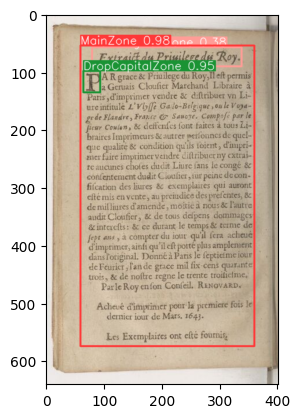

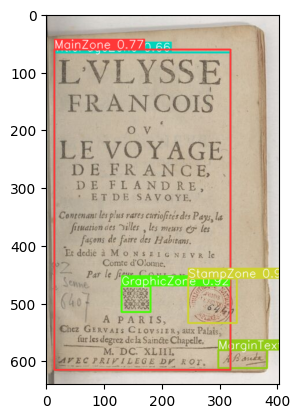

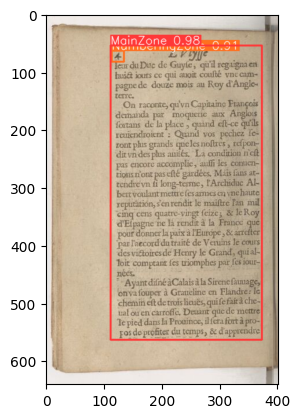

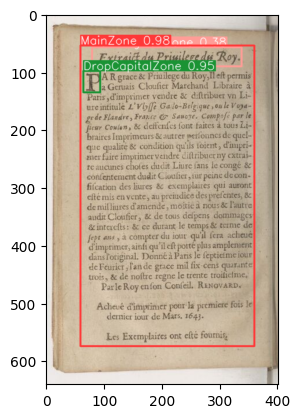

In [7]:
#model.fuse()

img = get_img("https://gallica.bnf.fr/iiif/ark:/12148/bpt6k9767960q/f24/full/,640/0/native.jpg")
img1 = get_img("https://gallica.bnf.fr/iiif/ark:/12148/bpt6k9767960q/f11/full/,640/0/native.jpg")
img2 = get_img("https://gallica.bnf.fr/iiif/ark:/12148/bpt6k9767960q/f28/full/,640/0/native.jpg")
img3 = get_img("https://gallica.bnf.fr/iiif/ark:/12148/bpt6k9767960q/f24/full/,640/0/native.jpg")

# Run inference on 'bus.jpg'
results = model([img, img1, img2, img3])  # results list
#results[0].boxes.data

# Show the results
for r in results:
    im_array = r.plot(conf=True)  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    #im.show()  # show image
    plt.imshow(im)
    plt.show()
    #im.save('results.jpg')  # save image

## EXPORT ONNX

In [2]:
model.export(format="onnx")

Model summary (fused): 268 layers, 68136087 parameters, 0 gradients, 257.5 GFLOPs

PyTorch: starting from 'models/best.pt' with input shape (1, 3, 896, 896) BCHW and output shape(s) (1, 17, 16464) (520.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 181.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 258.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.0s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 3.6s, saved as 'models/best.onnx' (260.3 MB)

Export complete (4.3s)
Results saved to /home/rayondemiel/yolov8-testing/models
Predict:         yolo predict task=detect model=models/best.onnx imgsz=896  
Validate:        yolo val task=detect model=models/best.onnx imgsz=896 data=/home/users/h/humeau/data/d

'models/best.onnx'